## Importing

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, TFDistilBertModel, TFDistilBertForSequenceClassification

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

nltk.download('stopwords')

# Load the dataset
train_data = pd.read_csv('/train.csv')
test_data = pd.read_csv('/test.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Cleaning

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

# Clean the reviews
train_data['cleaned_reviews'] = train_data['review'].apply(clean_text)
test_data['cleaned_reviews'] = test_data['review'].apply(clean_text)

# Encode the sentiment labels
train_data['sentiment_encoded'] = train_data['sentiment'].map({'pos': 1, 'neg': 0})
test_data['sentiment_encoded'] = test_data['sentiment'].map({'pos': 1, 'neg': 0})


## Tokenization and Model

In [9]:
# Split the data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Tokenization using DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


X_train = tokenizer(train_data['cleaned_reviews'].tolist(),
                    max_length=250,
                    padding=True,
                    truncation=True,
                    return_tensors='tf')

X_val = tokenizer(val_data['cleaned_reviews'].tolist(),
                  max_length=250,
                  padding=True,
                  truncation=True,
                  return_tensors='tf')

X_test = tokenizer(test_data['cleaned_reviews'].tolist(),
                   max_length=250,
                   padding=True,
                   truncation=True,
                   return_tensors='tf')

y_train = np.array(train_data['sentiment_encoded'])
y_val = np.array(val_data['sentiment_encoded'])
y_test = np.array(test_data['sentiment_encoded'])


# Build the model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tf.keras.Input(shape=(250,), dtype=tf.int32, name='input_ids')
attention_masks = tf.keras.Input(shape=(250,), dtype=tf.int32, name='attention_mask')

x = distilbert_model(inputs, attention_mask=attention_masks)[0][:, 0, :]
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs, attention_masks], outputs=outputs)

# Optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-6, weight_decay=1e-7)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBert

## Training

In [10]:
# Train
history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    epochs=5,
    batch_size=16,
    validation_data=([X_val['input_ids'], X_val['attention_mask']], y_val)
)

# Evaluate
loss, accuracy = model.evaluate([X_test['input_ids'], X_test['attention_mask']], y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict([X_test['input_ids'], X_test['attention_mask']])
y_pred = (y_pred > 0.5).astype(int)

Epoch 1/5
1250/1250 [==============================] - 109s 75ms/step - loss: 0.4514 - accuracy: 0.7762 - val_loss: 0.3233 - val_accuracy: 0.8674
Epoch 2/5
1250/1250 [==============================] - 74s 59ms/step - loss: 0.3168 - accuracy: 0.8702 - val_loss: 0.2995 - val_accuracy: 0.8708
Epoch 3/5
1250/1250 [==============================] - 70s 56ms/step - loss: 0.2743 - accuracy: 0.8890 - val_loss: 0.2901 - val_accuracy: 0.8812
Epoch 4/5
1250/1250 [==============================] - 69s 55ms/step - loss: 0.2497 - accuracy: 0.9010 - val_loss: 0.2902 - val_accuracy: 0.8818
Epoch 5/5
782/782 [==============================] - 27s 35ms/step - loss: 0.2632 - accuracy: 0.8946
Test Accuracy: 89.46%
782/782 [==============================] - 28s 34ms/step


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data

Precision: 0.8900
Recall: 0.9005
F1 Score: 0.8952
Test Accuracy: 89.46%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.89      0.89     12500
     Class 1       0.89      0.90      0.90     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



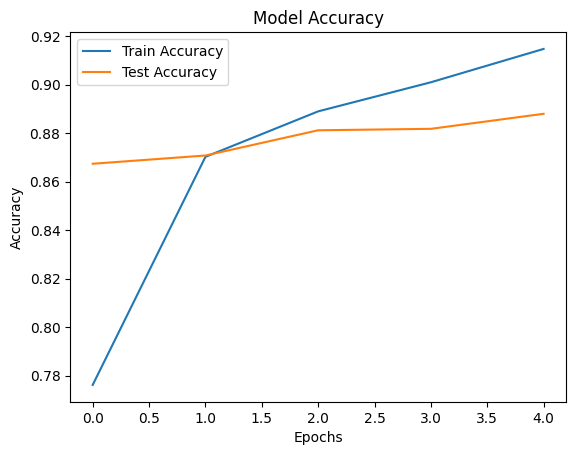

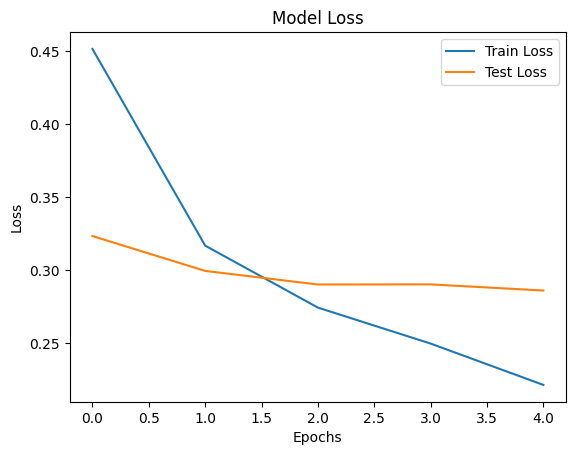

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 250)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 250, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

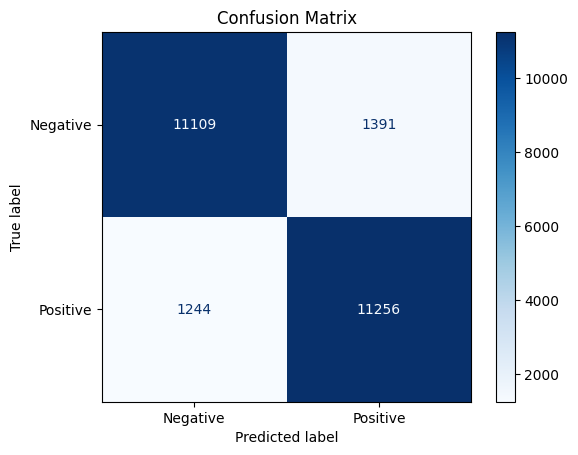

In [11]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", report)

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.summary()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Ablation Studies

In [12]:
# Build the model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tf.keras.Input(shape=(250,), dtype=tf.int32, name='input_ids')
attention_masks = tf.keras.Input(shape=(250,), dtype=tf.int32, name='attention_mask')

x = distilbert_model(inputs, attention_mask=attention_masks)[0][:, 0, :]
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs, attention_masks], outputs=outputs)

# Optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=1e-6)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train
history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    epochs=5,
    batch_size=16,
    validation_data=([X_val['input_ids'], X_val['attention_mask']], y_val)
)

# Evaluate
loss, accuracy = model.evaluate([X_test['input_ids'], X_test['attention_mask']], y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict([X_test['input_ids'], X_test['attention_mask']])
y_pred = (y_pred > 0.5).astype(int)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
1250/1250 [==============================] - 110s 76ms/step - loss: 0.3458 - accuracy: 0.8429 - val_loss: 0.2913 - val_accuracy: 0.8790
Epoch 2/5
1250/1250 [==============================] - 74s 59ms/step - loss: 0.1960 - accuracy: 0.9252 - val_loss: 0.2929 - val_accuracy: 0.8912
Epoch 3/5
1250/1250 [==============================] - 70s 56ms/step - loss: 0.1011 - accuracy: 0.9662 - val_loss: 0.3270 - val_accuracy: 0.8932
Epoch 4/5
1250/1250 [==============================] - 69s 56ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.5179 - val_accuracy: 0.8842
Epoch 5/5
782/782 [==============================] - 28s 35ms/step - loss: 0.4666 - accuracy: 0.8964
Test Accuracy: 89.64%
782/782 [==============================] - 28s 34ms/step


Precision: 0.9080
Recall: 0.8822
F1 Score: 0.8949
Test Accuracy: 89.64%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90     12500
     Class 1       0.91      0.88      0.89     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



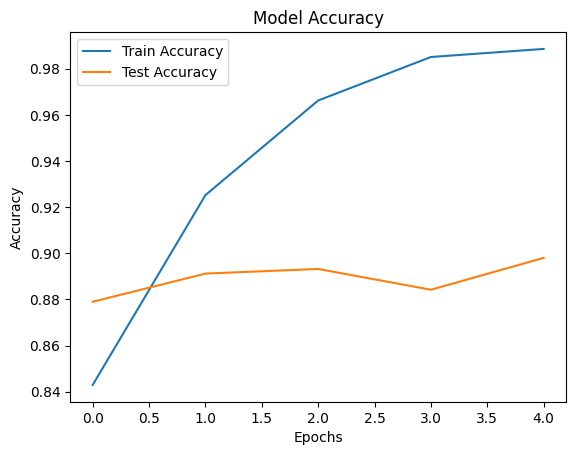

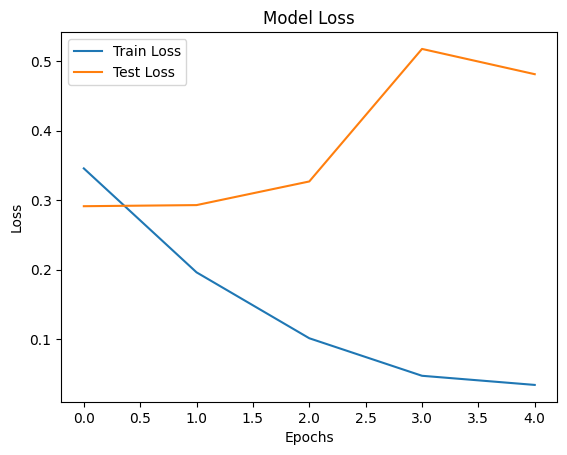

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 250)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_2 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 250, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

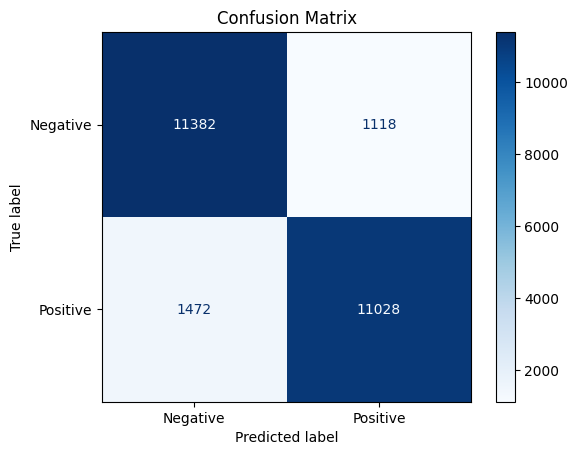

In [13]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", report)

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.summary()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()